# Exercise 4: recommender System

In [1]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


## Code from the lecture

In [11]:
#read data to DataFrames
import pandas as pd
import numpy as np
import scipy.spatial
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [24]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title)))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [4]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [17]:
def cos_distance(R):
    D_COS=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
    D_COS=np.abs(np.nan_to_num( D_COS-1)) #dist to similarity 
    np.fill_diagonal(D_COS,0) #set self-dist to zero
    return D_COS

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

In [14]:
def euc_distance(R):
    D_EUC = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='euclidean'))
    D_EUC=np.abs(np.nan_to_num( D_EUC-1)) #dist to similarity 
    np.fill_diagonal(D_EUC,0) #set self-dist to zero
    return D_EUC


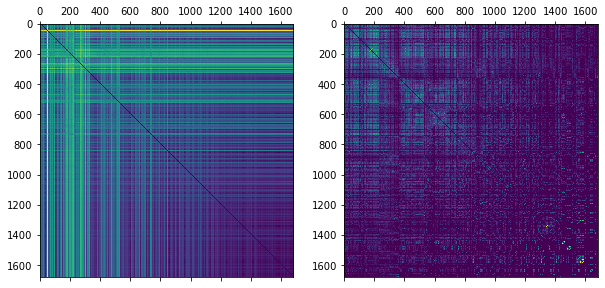

In [18]:
D_EUC = euc_distance(R)
D_COS = cos_distance(R)

np.save("euc_movie_dist", D_EUC)
np.save("cos_movie_dist", D_COS)

fig, axes = plt.subplots(1, 2)
axes[0].matshow(D_EUC)
axes[1].matshow(D_COS)

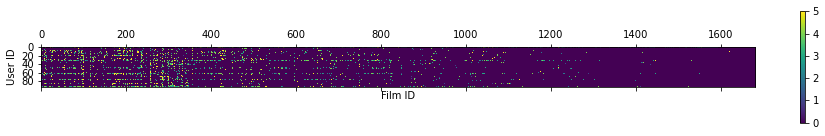

In [12]:
R_train, R_test = train_test_split(R, test_size=0.1)

plt.matshow(R_test)
plt.xlabel("Film ID")
plt.ylabel("User ID")
plt.colorbar()

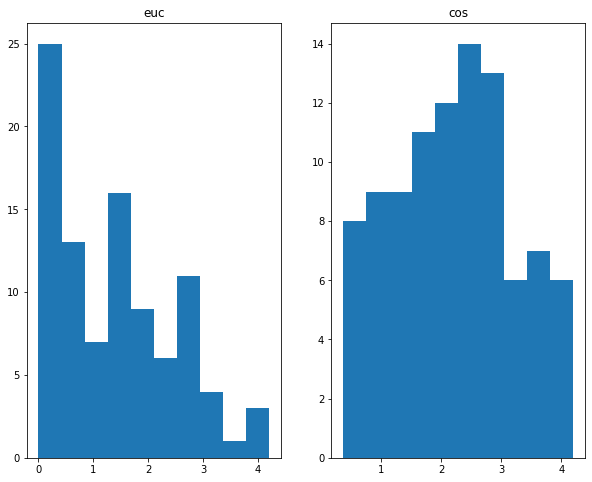

In [31]:
D_EUC_TRAIN = euc_distance(R_train)
D_COS_TRAIN = cos_distance(R_train)

euc_score = test_Score(D_EUC_TRAIN, R_test)
cos_score = test_Score(D_COS_TRAIN, R_test)

fig, axes = plt.subplots(1, 2)
axes[0].hist(euc_score)
axes[0].title.set_text('euc')
axes[1].hist(cos_score)
axes[1].title.set_text('cos')
plt.show()

## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $R$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct R and evaluate $R'$
* compute the distance between two movies using $R'$


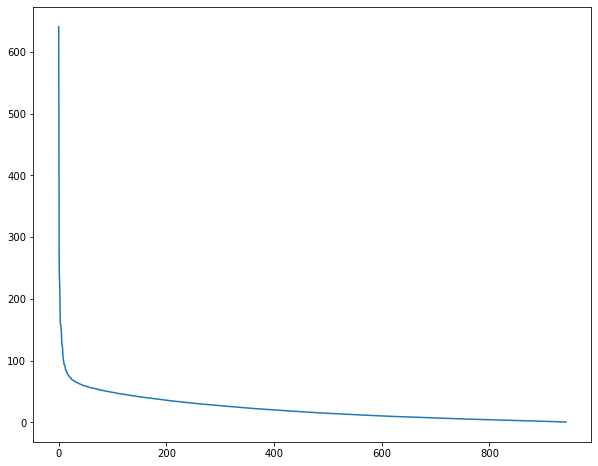

In [34]:
U, S, V = np.linalg.svd(R)
plt.plot(S)

In [38]:
singValue = 200

R_CUT = np.dot(U[:,:singValue] * S[:singValue], V[:singValue,:])

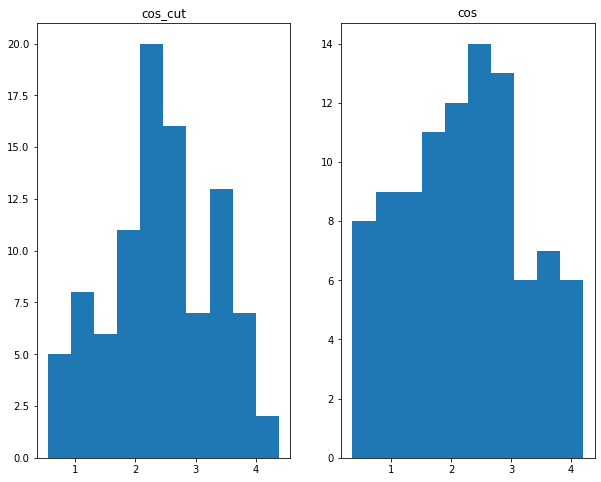

In [41]:
R_CUT_train, R_CUT_test = train_test_split(R_CUT, test_size=0.1)

D_COS_CUT_TRAIN = cos_distance(R_CUT_train)

cos_cut_score = test_Score(D_COS_CUT_TRAIN, R_CUT_test)


fig, axes = plt.subplots(1, 2)
axes[0].hist(cos_cut_score)
axes[0].title.set_text('cos_cut')
axes[1].hist(cos_score)
axes[1].title.set_text('cos')
plt.show()
